# Softmax exercise

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

Credit: [cs231n.stanford.edu](http://cs231n.stanford.edu)

In [106]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py** and **cs231n/classifiers/linear_classifier.py**

### Subtask 1
First implement the naive softmax loss function with nested loops.
Open the file cs231n/classifiers/softmax.py and implement the
softmax_loss_naive function.

In [16]:
from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.379527
sanity check: 2.302585


**Inline Question (1 point)**:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.

**Your answer:**  
The reason is that we have 10 classes in the dataset, and we initialize weight using small random values, so we can expect that initially the probability for each class will be 1/C, where C - number of classes.  
C = 10 for our case, so initially the probability for each class will be close to 0.1, after computing mean loss for the batch the result will be expected to be close to -np.log(0.1)

### Subtask 2 (1 point)
Complete the implementation of softmax_loss_naive and implement a (naive)
version of the gradient that _uses nested loops_.



In [4]:
W.shape, X_dev.shape, y_dev.shape

((3073, 10), (500, 3073), (500,))

In [50]:
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.055586 analytic: -0.055586, relative error: 8.064996e-07
numerical: -3.663107 analytic: -3.663107, relative error: 1.150493e-09
numerical: -3.236753 analytic: -3.236753, relative error: 8.356561e-09
numerical: -1.700413 analytic: -1.700413, relative error: 8.996457e-09
numerical: 1.407572 analytic: 1.407572, relative error: 1.622368e-08
numerical: 0.188807 analytic: 0.188807, relative error: 2.095608e-08
numerical: 1.588797 analytic: 1.588797, relative error: 4.523119e-08
numerical: -2.169292 analytic: -2.169292, relative error: 2.732255e-08
numerical: -2.113593 analytic: -2.113592, relative error: 2.358882e-08
numerical: -1.178201 analytic: -1.178201, relative error: 2.663616e-08
numerical: 2.111534 analytic: 2.111534, relative error: 2.104441e-08
numerical: 2.890171 analytic: 2.890171, relative error: 1.388094e-08
numerical: -2.416132 analytic: -2.416132, relative error: 7.234346e-09
numerical: -1.374033 analytic: -1.374033, relative error: 3.479313e-08
numerical: 1.549

### Subtask 3 (4 points)

Now that we have a naive implementation of the softmax loss function and its gradient,
implement a vectorized version in softmax_loss_vectorized.
The two versions should compute the same results, but the vectorized version should be
much faster.

In [88]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.379498e+00 computed in 0.126879s
vectorized loss: 2.379498e+00 computed in 0.002977s
Loss difference: 0.000000
Gradient difference: 0.000000


### Subtask 4 (2 points)

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [91]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
model = Softmax()
tic = time.time()
loss_hist = model.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                        num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 772.078898
iteration 100 / 1500: loss 283.530345
iteration 200 / 1500: loss 105.086262
iteration 300 / 1500: loss 39.828915
iteration 400 / 1500: loss 15.821467
iteration 500 / 1500: loss 7.145630
iteration 600 / 1500: loss 3.988802
iteration 700 / 1500: loss 2.708391
iteration 800 / 1500: loss 2.279774
iteration 900 / 1500: loss 2.156118
iteration 1000 / 1500: loss 2.121656
iteration 1100 / 1500: loss 2.104100
iteration 1200 / 1500: loss 2.087575
iteration 1300 / 1500: loss 2.068455
iteration 1400 / 1500: loss 2.057119
That took 16.277914s


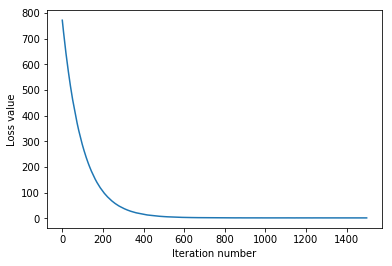

In [92]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [95]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = model.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = model.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.329469
validation accuracy: 0.346000


### Subtask 5 (2 points)

Use the validation set to tune hyperparameters (regularization strength and
learning rate). You should experiment with different ranges for the learning
rates and regularization strengths; if you are careful you should be able to
get a classification accuracy of over 0.35 on the validation set.

In [128]:
# learning_rates = [1e-7, 5e-7]
# regularization_strengths = [2.5e4, 5e4]

learning_rates = [5e-7, 3e-6]
regularization_strengths = [2.5e3, 5e3]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1       # The highest validation accuracy that we have seen so far.
best_softmax = None # The Softmax object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a Softmax clf on the     #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the Softmax object that achieves this    #
# accuracy in best_softmax.                                                    #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the Softmax don't take much time to train; once you  #
# are confident that your validation code works, you should rerun the          #
# validation code with a larger value for num_iters.                           #
################################################################################
import itertools
from tqdm import tqdm_notebook

num_iters = 25
lr_grid = np.logspace(*np.log10(learning_rates), 5)
reg_grid = np.logspace(*np.log10(regularization_strengths), 5)
params_grid = list(itertools.product(lr_grid, reg_grid))

for i in tqdm_notebook(range(num_iters)):
    softmax = Softmax()
    softmax.train(X_train, y_train, *params_grid[i], num_iters=500)
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    acc_train = np.mean(y_train_pred == y_train)
    acc_val = np.mean(y_val_pred == y_val)
    results[params_grid[i][0], params_grid[i][1]] = (acc_train, acc_val)
    
    if acc_val > best_val:
        best_val = acc_val
        best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


lr 5.000000e-07 reg 2.500000e+03 train accuracy: 0.339102 val accuracy: 0.365000
lr 5.000000e-07 reg 2.973018e+03 train accuracy: 0.348327 val accuracy: 0.361000
lr 5.000000e-07 reg 3.535534e+03 train accuracy: 0.353327 val accuracy: 0.357000
lr 5.000000e-07 reg 4.204482e+03 train accuracy: 0.363061 val accuracy: 0.375000
lr 5.000000e-07 reg 5.000000e+03 train accuracy: 0.366082 val accuracy: 0.372000
lr 7.825423e-07 reg 2.500000e+03 train accuracy: 0.374510 val accuracy: 0.367000
lr 7.825423e-07 reg 2.973018e+03 train accuracy: 0.372469 val accuracy: 0.376000
lr 7.825423e-07 reg 3.535534e+03 train accuracy: 0.373980 val accuracy: 0.383000
lr 7.825423e-07 reg 4.204482e+03 train accuracy: 0.370633 val accuracy: 0.370000
lr 7.825423e-07 reg 5.000000e+03 train accuracy: 0.369735 val accuracy: 0.387000
lr 1.224745e-06 reg 2.500000e+03 train accuracy: 0.379837 val accuracy: 0.386000
lr 1.224745e-06 reg 2.973018e+03 train accuracy: 0.377061 val accuracy: 0.386000
lr 1.224745e-06 reg 3.53553

In [129]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.369000


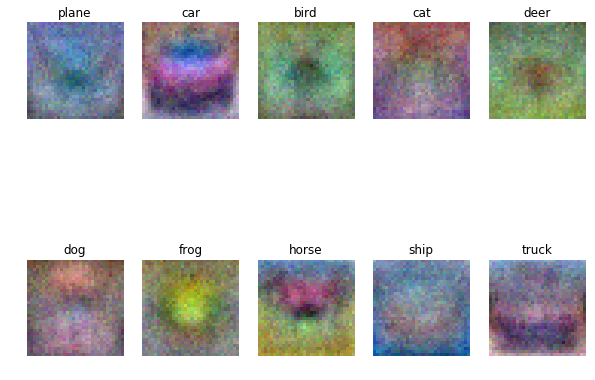

In [130]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

#### Max score: 10 points